<a href="https://colab.research.google.com/github/geon8074/practice-of-pytorch-tutorial/blob/main/practice_of_classfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
x = x.new_ones(5, 3, dtype=torch.double)      # new_* 메소드는 크기를 받습니다
print(x)

x = torch.randn_like(x, dtype=torch.float)    # dtype을 오버라이드(Override) 합니다!
print(x)   
print(x.size())   

import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 입력 이미지 채널 1개, 출력 채널 6개, 3x3의 정사각 컨볼루션 행렬
        # 컨볼루션 커널 정의
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # 아핀(affine) 연산: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6은 이미지 차원에 해당
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # (2, 2) 크기 윈도우에 대해 맥스 풀링(max pooling)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 크기가 제곱수라면 하나의 숫자만을 특정
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 배치 차원을 제외한 모든 차원
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)
params = list(net.parameters())
print(len(params))
print(params[0].size())
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)
net.zero_grad()
out.backward(torch.randn(1, 10))
output = net(input)
target = torch.randn(10)  # 예시를 위한 임의의 정답
target = target.view(1, -1)  # 출력과 같은 shape로 만듦
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU
net.zero_grad()     # 모든 매개변수의 변화도 버퍼를 0으로 만듦

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
    import torch.optim as optim

# Optimizer를 생성합니다.
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 학습 과정(training loop)에서는 다음과 같습니다:
optimizer.zero_grad()   # 변화도 버퍼를 0으로
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # 업데이트 진행

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
10
torch.Size([6, 1, 3, 3])
tensor([[-0.0692, -0.0483,  0.1116, -0.0521, -0.1688, -0.0655,  0.0420, -0.1614,
         -0.0555,  0.0331]], grad_fn=<AddmmBackward>)
tensor(1.9346, grad_fn=<MseLossBackward>)
conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0152, -0.0271, -0.0357,  0.0018,  0.0152,  0.0124])


In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


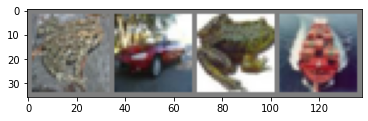

 frog   car  frog  ship


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.205
[1,  4000] loss: 1.819
[1,  6000] loss: 1.651
[1,  8000] loss: 1.545
[1, 10000] loss: 1.494
[1, 12000] loss: 1.447
[2,  2000] loss: 1.381
[2,  4000] loss: 1.345
[2,  6000] loss: 1.349
[2,  8000] loss: 1.305
[2, 10000] loss: 1.285
[2, 12000] loss: 1.262
Finished Training


In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

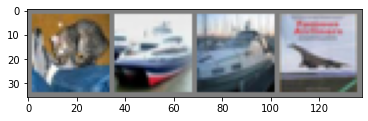

GroundTruth:    cat  ship  ship plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car plane  ship


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    


Accuracy of plane : 59 %
Accuracy of   car : 65 %
Accuracy of  bird : 36 %
Accuracy of   cat : 39 %
Accuracy of  deer : 42 %
Accuracy of   dog : 47 %
Accuracy of  frog : 62 %
Accuracy of horse : 75 %
Accuracy of  ship : 58 %
Accuracy of truck : 68 %


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)


cuda:0


In [17]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)
# %%%%%%INVISIBLE_CODE_BLOCK%%%%%%
del dataiter
# %%%%%%INVISIBLE_CODE_BLOCK%%%%%%